
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi


<font size=5 color=cyan> Names:</br></font>
<font size=4 color=orange>
MohammadReza Monemian</br>
Pouria Rahmani </br>
Nima Mollaee</br>
</font>
<font size=5 color=cyan>Student Numbers:</br></font>
<font size=4 color=orange>
402106604</br>
402111418</br>
402106553
</font>



In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [1]:
!pip install -q pybullet Box2D
!nvidia-smi


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Thu Sep  4 16:43:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              5W /   30W |     602MiB /   6144MiB |      0%      Default |
|                            

Import necessary packages.

In [2]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
# Correct: Import from the wrappers sub-module
from gymnasium.wrappers import RecordVideo
import gymnasium as gym
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video
from torch.distributions import Normal

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [3]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [4]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

oooccccccccccccccddskjlsdjlhuk## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [5]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, n_actions, fc1_dims=256, fc2_dims=256,
            name='critic', chkpt_dir='/home/amirm_eb/Desktop/1'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_sac')

        # state and action dimensions are concatenated
        self.fc1 = nn.Linear(self.input_dims[0] + n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        action_value = self.fc1(T.cat([state, action], dim=1))
        action_value = F.relu(action_value)
        action_value = self.fc2(action_value)
        action_value = F.relu(action_value)

        q = self.q(action_value)

        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

# This class is unchanged from your notebook
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, max_action, fc1_dims=256,
            fc2_dims=256, n_actions=2, name='actor', chkpt_dir='/home/amirm_eb/Desktop/1'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_sac')
        self.max_action = max_action
        self.reparam_noise = 1e-6

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        self.sigma = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)

        mu = self.mu(prob)
        sigma = self.sigma(prob)

        # We clamp the standard deviation to be within a stable range
        sigma = T.clamp(sigma, min=self.reparam_noise, max=1)

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)
        probabilities = Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.rsample() # Reparameterization trick
        else:
            actions = probabilities.sample()

        # Apply the squashing function and scale to action space
        action = T.tanh(actions) * T.tensor(self.max_action).to(self.device)
        
        # Calculate log probabilities, including the correction for the tanh squashing
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1 - action.pow(2) + self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [20]:
class Agent():
    def __init__(self, alpha, beta, input_dims,
            env, gamma, n_actions, max_size,max_action, tau,
            layer1_size, layer2_size, batch_size):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.max_action = max_action

        # --- Actor and Critic Networks ---
        self.actor = ActorNetwork(alpha, input_dims, n_actions=n_actions,fc1_dims = layer1_size,fc2_dims = layer2_size,
                    name='actor', max_action = self.max_action )
        
        self.critic_1 = CriticNetwork(beta, input_dims, n_actions=n_actions,fc1_dims = layer1_size,fc2_dims = layer2_size,
                    name='critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, n_actions=n_actions,fc1_dims = layer1_size,fc2_dims = layer2_size,
                    name='critic_2')

        # *** FIX ***: Removed the separate Value network.
        # --- Target Critic Networks for stable Q-learning targets ---
        self.target_critic_1 = CriticNetwork(beta, input_dims, n_actions=n_actions,fc1_dims = layer1_size,fc2_dims = layer2_size,
                    name='target_critic_1')
        self.target_critic_2 = CriticNetwork(beta, input_dims, n_actions=n_actions,fc1_dims = layer1_size,fc2_dims = layer2_size,
                    name='target_critic_2')
        
        # *** FIX ***: Added automatic temperature (alpha) tuning
        self.log_alpha = T.zeros(1, requires_grad=True, device=self.actor.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=alpha)
        # Target entropy is a heuristic. A common choice is -|A|, the negative of the action dimension.
        self.target_entropy = -T.tensor(n_actions, dtype=T.float).to(self.actor.device)

        self.update_network_parameters(tau=1) # Initialize target networks to match main networks

    def choose_action(self, observation):
        state = T.Tensor(np.array([observation])).to(self.actor.device)
        # When acting in the environment, we don't need reparameterization
        actions, _ = self.actor.sample_normal(state, reparameterize=False)

        return actions.cpu().detach().numpy()[0]

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        # --- Update Target Critic 1 ---
        target_critic_1_params = self.target_critic_1.named_parameters()
        critic_1_params = self.critic_1.named_parameters()
        target_critic_1_state_dict = dict(target_critic_1_params)
        critic_1_state_dict = dict(critic_1_params)
        for name in critic_1_state_dict:
            critic_1_state_dict[name] = tau * critic_1_state_dict[name].clone() + \
                (1 - tau) * target_critic_1_state_dict[name].clone()
        self.target_critic_1.load_state_dict(critic_1_state_dict)

        # --- Update Target Critic 2 ---
        target_critic_2_params = self.target_critic_2.named_parameters()
        critic_2_params = self.critic_2.named_parameters()
        target_critic_2_state_dict = dict(target_critic_2_params)
        critic_2_state_dict = dict(critic_2_params)
        for name in critic_2_state_dict:
            critic_2_state_dict[name] = tau * critic_2_state_dict[name].clone() + \
                (1 - tau) * target_critic_2_state_dict[name].clone()
        self.target_critic_2.load_state_dict(critic_2_state_dict)

    def save_models(self):
        print('.... saving models ....')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()

    def load_models(self):
        print('.... loading models ....')
        self.actor.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()
        self.target_critic_1.load_checkpoint()
        self.target_critic_2.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        # Convert numpy arrays to tensors
        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)
        
        # *** FIX ***: Cast the 'done' tensor to float to allow for arithmetic operations
        done = T.tensor(done, dtype=T.float).to(self.actor.device)
        
        state_ = T.tensor(new_state, dtype=T.float).to(self.actor.device)
        state = T.tensor(state, dtype=T.float).to(self.actor.device)
        action = T.tensor(action, dtype=T.float).to(self.actor.device)

        with T.no_grad():
            next_actions, next_log_probs = self.actor.sample_normal(state_, reparameterize=True)
            
            target_q1_values = self.target_critic_1.forward(state_, next_actions)
            target_q2_values = self.target_critic_2.forward(state_, next_actions)
            target_q_values = T.min(target_q1_values, target_q2_values).view(-1)
            
            alpha = self.log_alpha.exp()
            # The (1 - done) term will now work correctly
            next_target = reward + self.gamma * (1 - done) * (target_q_values - alpha * next_log_probs.view(-1))

        # --- Update Critic Networks ---
        q1_values = self.critic_1.forward(state, action).view(-1)
        q2_values = self.critic_2.forward(state, action).view(-1)
        
        critic_1_loss = 0.5 * F.mse_loss(q1_values, next_target)
        critic_2_loss = 0.5 * F.mse_loss(q2_values, next_target)
        critic_loss = critic_1_loss + critic_2_loss
        
        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()
        
        # --- Update Actor and Alpha (Temperature) ---
        actions, log_probs = self.actor.sample_normal(state, reparameterize=True)
        
        q1_new_policy = self.critic_1.forward(state, actions)
        q2_new_policy = self.critic_2.forward(state, actions)
        min_q_new_policy = T.min(q1_new_policy, q2_new_policy).view(-1)

        actor_loss = (alpha.detach() * log_probs.view(-1) - min_q_new_policy).mean()
        
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        # --- Alpha (temperature) loss ---
        alpha_loss = -(self.log_alpha * (log_probs.detach() + self.target_entropy)).mean()
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # --- Soft update target networks ---
        self.update_network_parameters()

## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [21]:
env_name = 'HalfCheetah' 
dir = '/home/amirm_eb/Desktop/1'
n_games = 250

gamma = 0.99
alpha_lr = 3e-4 
beta_lr = 3e-4 
fc1_dim = 256
fc2_dim = 256
memory_size = 1000000
batch_size = 256
tau = 0.005
warmup = 1000 
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

  0%|          | 0/250 [00:00<?, ?it/s]

.... saving models ....
| Game:      0 | Score:    -320.26 | Best Avg Score:    -320.26 | Avg score    -320.26 | Steps: 1000
| Game:      1 | Score:    -470.29 | Best Avg Score:    -320.26 | Avg score    -395.28 | Steps: 2000
| Game:      2 | Score:    -242.56 | Best Avg Score:    -320.26 | Avg score    -344.37 | Steps: 3000
| Game:      3 | Score:    -292.78 | Best Avg Score:    -320.26 | Avg score    -331.47 | Steps: 4000
| Game:      4 | Score:    -405.44 | Best Avg Score:    -320.26 | Avg score    -346.27 | Steps: 5000
| Game:      5 | Score:    -222.36 | Best Avg Score:    -320.26 | Avg score    -325.62 | Steps: 6000
.... saving models ....
| Game:      6 | Score:    -165.62 | Best Avg Score:    -302.76 | Avg score    -302.76 | Steps: 7000
.... saving models ....
| Game:      7 | Score:    -154.56 | Best Avg Score:    -284.23 | Avg score    -284.23 | Steps: 8000
.... saving models ....
| Game:      8 | Score:    -194.88 | Best Avg Score:    -274.31 | Avg score    -274.31 | Steps: 

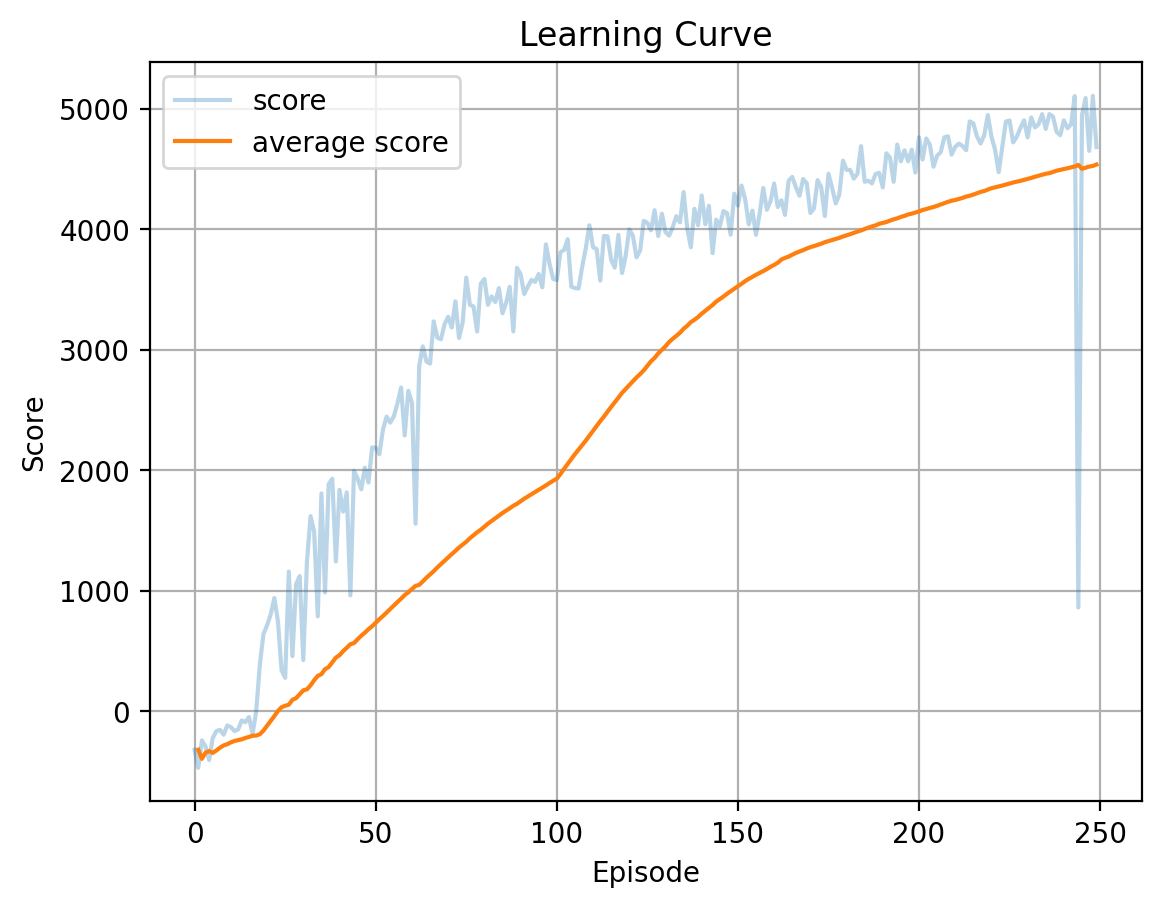

In [22]:
env = gym.make(env_name, render_mode="rgb_array")
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)


# *** FIX ***: Instantiate agent with the correct (modern) parameters
agent = Agent(alpha=alpha_lr, beta=beta_lr, input_dims=env.observation_space.shape,
              env=env,gamma = gamma, n_actions=env.action_space.shape[0],max_size = memory_size,
              max_action = float(env.action_space.high[0]),tau =tau,
              layer1_size =fc1_dim,layer2_size = fc2_dim, batch_size=batch_size)

scores = []
best_score = -np.inf

# Add a warmup phase
num_steps = 0

for game in trange(n_games):
    observation, info = env.reset()
    score = 0
    done = False

    while not (done):
        if num_steps < warmup:
            # Take random actions during the warmup phase to fill the buffer
            action = env.action_space.sample()
        else:
            action = agent.choose_action(observation)

        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score += reward
        agent.store_transition(observation, action, reward, next_observation, done)
        
        if num_steps >= warmup:
            agent.learn()
            
        observation = next_observation
        num_steps += 1

    scores.append(score)
    avg_score = np.mean(scores[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best Avg Score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Steps: {num_steps}')

env.close()

plot_learning_curve(scores, os.path.join(dir_path, 'sac_agent_fixed_learning_curve'))

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [ ]:
Video(f"/home/amirm_eb/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)